In [1]:
#code by Hannes Mueller, May 2021
#Please cite our article "Monitoring War Destruction from Space Using Machine Learning" when using parts of this code
#Questions regarding the code and suggestions for improvement to h.mueller.uni@gmail.com

#This code uses STATA to merge datasets. It is probably possible to achieve the same result in Python.

#Strucuture of the code
#1) generate features from first stage fitted values
#2) train and test on 70/30 sample split
#3) produce fitted values for out-of-sample studies using all data for training

import pandas as pd
import numpy as np
import csv
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
import math

from sklearn.ensemble import RandomForestClassifier

from scipy import interp

import os

import subprocess


In [8]:
#change to your replication folder here
path='/mnt/c/Users/natra/Documents/Research/conflict-data/mueller_monitoring_destruction/Syria-Second-Stage/'
spitout='/mnt/c/Users/natra/Documents/Research/conflict-data/mueller_monitoring_destruction/Syria-Second-Stage/'
#this program calls STATA - you need to give you STATA path
#STATA 15 should not be necessary to run this code
statapath="/mnt/c/Program Files/Stata17/StataBE-64.exe"
path_for_stata="C:/Users/natra/Documents/Research/conflict-data/mueller_monitoring_destruction/Syria-Second-Stage/"
spitout_for_stata="C:/Users/natra/Documents/Research/conflict-data/mueller_monitoring_destruction/Syria-Second-Stage/"


In [21]:
#feature generation starts here
#two datasets are loaded - the fitted values from the first stage and the label (target) files

#the structure of the first stage output file names is, for example, prediction_all_homs
city="all"
#traincities=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]
traincities=["deir-ez-zor"]

for traincity in traincities:
    filename ="prediction_"+city+"_"+traincity+".p"
    # uploading the data
    corpus_data = pd.read_pickle(os.path.join(path, filename))
    corpus_data.to_csv(spitout + "only_prediction.csv", sep='\t', encoding='utf-8')
    
    #target files include the "destroyed" variable which are the labels
    filename ="target_"+traincity+".p"
    # uploading the data
    train_data = pd.read_pickle(os.path.join(path, filename))
    train_data.to_csv(spitout + traincity + "_noimages.csv", sep='\t', encoding='utf-8')

    #call stata to merge
    dofile = path_for_stata+"merge-dense-prediction-other.do"
    #print("dofile",dofile)
    cmd = [statapath, "-e", "do", dofile, traincity, path_for_stata, spitout_for_stata]
    subprocess.call(cmd)

    #this file is made in the stata do file
    filename ="prediction_"+traincity+".csv"

    # uploading the data
    corpus_data = pd.read_csv(os.path.join(path, filename))
    corpus_data.info()

    corpus_data=corpus_data.dropna(subset=['longitude', 'latitude'])
    
    #we take the cutoff value for binary predictions from the code below
    #this cutoff is chosen in the pooled sample to reach 50% tpr
    corpus_data['pred_50recall']=(corpus_data.prediction>0.8515)*1

    corpus_data['pred_50recall_l1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(1)
    corpus_data['pred_50recall_l2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(2)

    corpus_data['pred_50recall_f1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-1)
    corpus_data['pred_50recall_f2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-2)


    corpus_data['prediction_l1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(1)
    corpus_data['prediction_l2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(2)

    corpus_data['prediction_f1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-1)
    corpus_data['prediction_f2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-2)

    updated_data = pd.DataFrame({"patch_id": pd.Series([]), "futurepred": pd.Series([]), "futurecount": pd.Series([]),
                        "futurestd": pd.Series([]), "date": pd.Series([])})

    #for date in corpus_data.index.get_level_values('date').unique():
    for date in corpus_data.date.unique():
        print(date)
        future = corpus_data.drop(corpus_data[(corpus_data.date <= date)].index)
        futurepred=future.groupby('patch_id').agg(['mean', 'count', 'std']).prediction.reset_index()
        futurepred['date']=date
        futurepred.columns=['patch_id', 'futurepred', 'futurecount', 'futurestd', 'date']
        updated_data=updated_data.append(futurepred)
        del futurepred



    corpus_data=corpus_data.merge(updated_data, on=['patch_id', 'date'], how='outer')
    corpus_data.info()
    del updated_data

    updated_data = pd.DataFrame({"date": pd.Series([]), "sum": pd.Series([]), "count": pd.Series([]), "std": pd.Series([]),
                             "sum2": pd.Series([]), "count2": pd.Series([]), "std2": pd.Series([]), "sum_bin": pd.Series([]),
                             "sum_bin2": pd.Series([]), "latitude": pd.Series([]), "longitude": pd.Series([])})

    #loop through lat and long
    for lat in corpus_data.latitude.unique():
        for long in corpus_data.longitude.unique():
            #makes the sum, count and std of patches within a radius (given by sqrt(0.00000085)) which makes two spatial lags
            #print('corpus_data',corpus_data.head())
            #print(corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
            #        +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000085].groupby('date').sum())
            rowsum=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000085].\
                        drop(columns=['city','patch_id']).groupby('date').agg(['sum', 'count','std']).prediction.reset_index()
            #makes the sum, count and std of patches within a radius (given by sqrt(0.00000028)) which makes one spatial lag
            rowsum2=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000028].\
                        drop(columns=['city','patch_id']).groupby('date').agg(['sum', 'count','std']).prediction.reset_index()
    
            rowsum['sum2']=rowsum2['sum']
            rowsum['count2']=rowsum2['count']
            rowsum['std2']=rowsum2['std']
            #same with binary values - one spatial lag
            rowsum2=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000028].groupby('date').agg(['sum']).pred_50recall.reset_index()
            rowsum['sum_bin']=rowsum2['sum']
            #same with binary values - two spatial lags
            rowsum2=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000085].groupby('date').agg(['sum']).pred_50recall.reset_index()
            rowsum['sum_bin2']=rowsum2['sum']
        
            rowsum['latitude']=lat
            rowsum['longitude']=long
            updated_data=updated_data.append(rowsum)
            del rowsum
        print("done latitude", lat, "in", traincity)
    
    updated_data.columns= ['date', 'sum2', 'count2', 'std2', 'sum', 'count', 'std', 'sum_bin', 'sum_bin2', 'latitude', 'longitude']
    updated_data.to_csv(spitout + "prediction_features_"+city+"_"+traincity+".csv", sep='\t', encoding='utf-8')

    #after running the above code merge
    updated ="prediction_features_"+city+"_"+traincity+".csv"

    # uploading the data
    updated_data = pd.read_csv(os.path.join(path, updated), sep='\t', encoding='utf-8')
    updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98602 entries, 0 to 98601
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         98602 non-null  object 
 1   patch_id     98602 non-null  object 
 2   date         98602 non-null  object 
 3   destroyed    84723 non-null  float64
 4   latitude     98602 non-null  float64
 5   longitude    98602 non-null  float64
 6   no_analysis  98602 non-null  int64  
 7   prediction   98602 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.0+ MB
2013-10-24
2014-09-16


/tmp/ipykernel_18420/1365468332.py:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  updated_data = pd.DataFrame({"patch_id": pd.Series([]), "futurepred": pd.Series([]), "futurecount": pd.Series([]),
/tmp/ipykernel_18420/1365468332.py:54: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "futurestd": pd.Series([]), "date": pd.Series([])})


2014-10-15
2014-11-25
2016-04-17
2016-05-25
2016-07-06
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98602 entries, 0 to 98601
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              98602 non-null  object 
 1   patch_id          98602 non-null  object 
 2   date              98602 non-null  object 
 3   destroyed         84723 non-null  float64
 4   latitude          98602 non-null  float64
 5   longitude         98602 non-null  float64
 6   no_analysis       98602 non-null  int64  
 7   prediction        98602 non-null  float64
 8   pred_50recall     98602 non-null  int64  
 9   pred_50recall_l1  84516 non-null  float64
 10  pred_50recall_l2  70430 non-null  float64
 11  pred_50recall_f1  84516 non-null  float64
 12  pred_50recall_f2  70430 non-null  float64
 13  prediction_l1     84516 non-null  float64
 14  prediction_l2     70430 non-null  float64
 15  prediction_f1     84516 non-null

/tmp/ipykernel_18420/1365468332.py:72: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  updated_data = pd.DataFrame({"date": pd.Series([]), "sum": pd.Series([]), "count": pd.Series([]), "std": pd.Series([]),
/tmp/ipykernel_18420/1365468332.py:73: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "sum2": pd.Series([]), "count2": pd.Series([]), "std2": pd.Series([]), "sum_bin": pd.Series([]),
/tmp/ipykernel_18420/1365468332.py:74: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "sum_bin2": pd.Series([]), "latitude": pd.Series([]), "longitude": pd.Series([])})


done latitude 35.355202 in deir-ez-zor
done latitude 35.354858 in deir-ez-zor
done latitude 35.354515 in deir-ez-zor
done latitude 35.354172 in deir-ez-zor
done latitude 35.353828 in deir-ez-zor
done latitude 35.353485 in deir-ez-zor
done latitude 35.353142 in deir-ez-zor
done latitude 35.352798 in deir-ez-zor
done latitude 35.352455 in deir-ez-zor
done latitude 35.360008 in deir-ez-zor
done latitude 35.352112 in deir-ez-zor
done latitude 35.351768 in deir-ez-zor
done latitude 35.351425 in deir-ez-zor
done latitude 35.351082 in deir-ez-zor
done latitude 35.359665 in deir-ez-zor
done latitude 35.359322 in deir-ez-zor
done latitude 35.360695 in deir-ez-zor
done latitude 35.358978 in deir-ez-zor
done latitude 35.341812 in deir-ez-zor
done latitude 35.341469 in deir-ez-zor
done latitude 35.341125 in deir-ez-zor
done latitude 35.340782 in deir-ez-zor
done latitude 35.340439 in deir-ez-zor
done latitude 35.340096 in deir-ez-zor
done latitude 35.339752 in deir-ez-zor
done latitude 35.358635 i

In [22]:
updated_data.shape

(110320, 12)

In [70]:
#2) second stage estimation and application and calculation of table 1 starts here
#this is the main part of the code

#we first define programs and then run training and testing for the second stage

#readcity takes files as they are generated by the dense prediction maker after the CNN (first stage)
#it then merges this dense prediction data with the features generated in the feature generationg code using STATA
#note that dense prediction still implies a training/test partition which we mantain throughout
#the only exception is the very last step in which we train using all the labelled data to print out predicted values

def readcity(cityname, targetcity):
    filename ="prediction_"+cityname+"_"+targetcity+".p"
    # uploading the data
    corpus_data = pd.read_pickle(os.path.join(path, filename))
    corpus_data.to_csv(spitout + "only_prediction.csv", sep='\t', encoding='utf-8')
    filename ="target_"+targetcity+".p"
    # uploading the data
    target_data = pd.read_pickle(os.path.join(path, filename))
    target_data.to_csv(spitout + targetcity + "_noimages.csv", sep='\t', encoding='utf-8')

    #call STATA to merge datasets
    dofile = path_for_stata+"merge-dense-prediction-other.do"
    cmd = [statapath, "-e", "do", dofile, targetcity, path_for_stata, spitout_for_stata]
    subprocess.call(cmd)

    #this file is made in the stata do file and contains the merge
    filename_city ="prediction_"+targetcity+".csv"

    # uploading the data
    corpus_data = pd.read_csv(os.path.join(path, filename_city))
    corpus_data.info()
    
    #the following features are not used but used to be generated
    corpus_data['pred_50recall']=(corpus_data.prediction>0.8515)*1

    corpus_data['pred_50recall_l1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(1)
    corpus_data['pred_50recall_l2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(2)

    corpus_data['pred_50recall_f1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-1)
    corpus_data['pred_50recall_f2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-2)

    #doing padding
    vlist=['pred_50recall_l1', 'pred_50recall_l2', 'pred_50recall_f1', 'pred_50recall_f2']
    for var in vlist:
        corpus_data[var]=corpus_data[var].combine_first(corpus_data["pred_50recall"])

    corpus_data['prediction_l1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(1)
    corpus_data['prediction_l2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(2)

    corpus_data['prediction_f1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-1)
    corpus_data['prediction_f2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-2)

    #doing padding
    vlist=['prediction_l1', 'prediction_l2', 'prediction_f1', 'prediction_f2']
    for var in vlist:
        corpus_data[var]=corpus_data[var].combine_first(corpus_data["prediction"])

    corpus_data["latitude"]=corpus_data.latitude.round(6)
    corpus_data["longitude"]=corpus_data.longitude.round(6)
    #the file below comes from a different file that needs to be run first
    updated ="prediction_features_"+cityname+"_"+targetcity+".csv"


    # uploading the data
    updated_data = pd.read_csv(os.path.join(path, updated), sep='\t', encoding='utf-8')
    del updated_data['Unnamed: 0']
    updated_data["latitude"]=updated_data.latitude.round(6)
    updated_data["longitude"]=updated_data.longitude.round(6)

    corpus_data_add=corpus_data.merge(updated_data, on=['latitude', 'longitude', 'date'], how='inner')


    del corpus_data
    del updated_data
    return corpus_data_add




In [129]:
#this codes uses data that is passed to estimate four models
#full model (spatial information and two lags of temporal information)
#model using just spatial information
#model just using temporal information
#full model but with only using one temporal lag

def estimatemodel(corpus_data2, cityname):
    #add features
    corpus_data2["count1"]=corpus_data2["count"]-1
    corpus_data2["count2"]=corpus_data2["count2"]-1

    corpus_data2["pred_c1"]=(corpus_data2["sum"]-corpus_data2["prediction"])/corpus_data2["count"]
    corpus_data2["pred_c2"]=(corpus_data2["sum2"]-corpus_data2["prediction"])/corpus_data2["count2"]

    corpus_data2["pred_50recall_c1"]=(corpus_data2["sum_bin"]-corpus_data2["pred_50recall"])/corpus_data2["count"]
    corpus_data2["pred_50recall_c2"]=(corpus_data2["sum_bin2"]-corpus_data2["pred_50recall"])/corpus_data2["count2"]


    #simplest possible model
    model = []
    model.append("prediction")
    model.append("destroyed")
    model.append("prediction_l1")
    model.append("prediction_l2")
    model.append("prediction_f1")
    model.append("prediction_f2")
    model.append("std")
    model.append("std2")
    model.append("count")
    model.append("count2")
    model.append("sum_bin")
    model.append("sum_bin2")

    model.append("pred_c1")
    model.append("pred_c2")


    data = corpus_data2[model]
    data = data.dropna(how='any').reset_index()

    data.info()

    y_within=data.destroyed

    preds_within=data.prediction

    preds_avrg=(data["prediction"]+data["prediction_f1"]+data["prediction_f2"])/3


    
    model_RF=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF1=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2']
    model_RF2=['prediction', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF3=['prediction', 'prediction_l1', 'prediction_f1', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]

    print("data head",data.head())
    print('corpus data head',corpus_data2.head())

    X_RF=data[model_RF]
    X_RF_dense=corpus_data2[model_RF]
    
    X_RF1=data[model_RF1]
    X_RF1_dense=corpus_data2[model_RF1]

    X_RF2=data[model_RF2]
    X_RF2_dense=corpus_data2[model_RF2]

    X_RF3=data[model_RF3]
    X_RF3_dense=corpus_data2[model_RF3]
    
    clf_RF = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1)
    clf_RF2 = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1 )
    clf_RF1 = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1 )
    clf_RF3 = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1 )
        
        
    print("estimating forest with lags")
    print('X_RF',X_RF)
    print("y_within",y_within)
    
    print('X_RF shape',X_RF.shape)
    print('X_RF na shape',X_RF.isna().shape)
    
    
    clf_RF.fit(X_RF.dropna(),y_within)
        
    print("estimating forest with only spatial lags")
    clf_RF2.fit(X_RF2,y_within)
    
    print("estimating forest with only temporal lags")
    clf_RF1.fit(X_RF1,y_within)
    
    print("estimating forest with one temporal lag")
    clf_RF3.fit(X_RF3,y_within)
    
    p_RF_within = clf_RF.predict_proba(X_RF)[:, 1]
    p_RF2_within = clf_RF2.predict_proba(X_RF2)[:, 1]
    p_RF1_within = clf_RF1.predict_proba(X_RF1)[:, 1]
    p_RF3_within = clf_RF3.predict_proba(X_RF3)[:, 1]
    p_ENS_within = np.mean([p_RF1_within, p_RF2_within], axis=0)

    
    corpus_data2["random_forest_pred"] = clf_RF.predict_proba(X_RF_dense)[:, 1]
    corpus_data2["random_forest_pred_sp"] = clf_RF2.predict_proba(X_RF2_dense)[:, 1]
    corpus_data2["random_forest_temp"] = clf_RF1.predict(X_RF1_dense)
    corpus_data2["random_forest_full1l"] = clf_RF3.predict(X_RF3_dense)
    
    #corpus_data2.to_csv(spitout + "prediction_MLcleaned_"+cityname+".csv", sep='\t', encoding='utf-8')


    
    return clf_RF, clf_RF2, clf_RF1, clf_RF3, y_within, preds_within, p_RF_within, p_RF2_within, p_RF1_within, p_RF3_within
    
    return X_RF, y_within, X_RF_dense


In [72]:
#apply to calculate AUC

def applymodel(clf_RF_app, clf_RF2_app, clf_RF1_app, clf_RF3_app, cityname, corpus_data2, printing):
    print("Looking at ", cityname)
    #add features
    corpus_data2["count1"]=corpus_data2["count"]-1
    corpus_data2["count2"]=corpus_data2["count2"]-1

    corpus_data2["pred_c1"]=(corpus_data2["sum"]-corpus_data2["prediction"])/corpus_data2["count"]
    corpus_data2["pred_c2"]=(corpus_data2["sum2"]-corpus_data2["prediction"])/corpus_data2["count2"]

    corpus_data2["pred_50recall_c1"]=(corpus_data2["sum_bin"]-corpus_data2["pred_50recall"])/corpus_data2["count"]
    corpus_data2["pred_50recall_c2"]=(corpus_data2["sum_bin2"]-corpus_data2["pred_50recall"])/corpus_data2["count2"]


    #simplest possible model
    model = []
    model.append("prediction")
    model.append("destroyed")
    model.append("prediction_l1")
    model.append("prediction_l2")
    model.append("prediction_f1")
    model.append("prediction_f2")
    model.append("std")
    model.append("std2")
    model.append("count")
    model.append("count2")
    model.append("sum_bin")
    model.append("sum_bin2")

    model.append("pred_c1")
    model.append("pred_c2")


    data_app = corpus_data2[model]
    data_app = data_app.dropna(how='any').reset_index()

    data_app.info()
    
    y=data_app.destroyed

    preds=data_app.prediction


    model_RF=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF1=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2']
    model_RF2=['prediction', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF3=['prediction', 'prediction_l1', 'prediction_f1', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]


    X_RF=data_app[model_RF]
    X_RF_dense=corpus_data2[model_RF]
    
    X_RF1=data_app[model_RF1]
    X_RF1_dense=corpus_data2[model_RF1]

    X_RF2=data_app[model_RF2]
    X_RF2_dense=corpus_data2[model_RF2]

    X_RF3=data_app[model_RF3]
    X_RF3_dense=corpus_data2[model_RF3]


    weight = y.shape[0]/(2*np.bincount(y))
    weightloss=weight[1]/weight[0]
    print("this means the zeros have a weight that is", weightloss, "times higher")

    unb_weights=class_weight.compute_sample_weight({0:1,1:1}, y)

    b_weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y)
        
    print("apply forest")
    p_RF = clf_RF_app.predict_proba(X_RF)[:, 1]
    print("apply temporal")
    p_RF1 = clf_RF1_app.predict_proba(X_RF1)[:, 1]
    print("apply spatial")
    p_RF2 = clf_RF2_app.predict_proba(X_RF2)[:, 1]
    print("apply one lag model")
    p_RF3 = clf_RF3_app.predict_proba(X_RF3)[:, 1]


        
    p_ENS = np.mean([p_RF1, p_RF2], axis=0)
    
    if printing==1:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        precs = []

        avprecs=[]

        i=1
        print("Producing graphs for "+cityname)

        fpr, tpr, thresholds = roc_curve(y, preds, sample_weight=b_weights)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=4, color='cornflowerblue',
            label='ROC curve first stage (AUC = %0.2f)' % (roc_auc))

        fpr, tpr, thresholds = roc_curve(y, p_RF, sample_weight=b_weights)
        
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        roc_auc2 = auc(fpr, tpr)
        
        
        plt.plot(fpr, tpr, lw=4, color='maroon', linestyle='--',
            label='ROC curve second stage (AUC = %0.2f)' % (roc_auc2))


        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)


        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.savefig(spitout+'auc_'+cityname+'.pdf')
        plt.savefig(spitout+'auc_'+cityname+'.eps')
        plt.show()
        
        #save stuff out
        arr = np.concatenate((fpr, tpr))
        pd.DataFrame(arr).to_csv(path+"rocdata.csv")
        pd.DataFrame(fpr).to_csv(path+"fprdata.csv")
        pd.DataFrame(tpr).to_csv(path+"tprdata.csv")



        #precision recall
        precision, recall, thresholds = precision_recall_curve(y, preds, sample_weight=unb_weights)
        avprec=average_precision_score(y, preds, sample_weight=unb_weights)

        plt.plot(recall, precision, lw=4, color='cornflowerblue',
            label='unb. sample, CNN only (av. Pr. = %0.2f)' % (avprec))

        precision, recall, thresholds = precision_recall_curve(y, p_RF2, sample_weight=unb_weights)
        avprec=average_precision_score(y, p_RF2, sample_weight=unb_weights)

        plt.plot(recall, precision, lw=3, color='darkviolet', linestyle=':',
            label='unb. sample, CNN + spatial (av. Pr. = %0.2f)' % (avprec))


        precision, recall, thresholds = precision_recall_curve(y, p_RF, sample_weight=unb_weights)
        avprec=average_precision_score(y, p_RF, sample_weight=unb_weights)

        plt.plot(recall, precision, lw=4, color='maroon', linestyle='--',
            label='unb. sample, CNN + spatial + temporal (av. Pr. = %0.2f)' % (avprec))



        plt.xlim([0.001, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        #plt.title('Precision Recall Curves')
        plt.legend(loc="upper right")
        plt.savefig(spitout+'precision_'+cityname+'.pdf')
        plt.savefig(spitout+'precision_'+cityname+'.eps')
        plt.show()

        print("precision in the balanced sample with rf is", average_precision_score(y, p_RF, sample_weight=b_weights))
        print("precision in the unbalanced sample with rf is", average_precision_score(y, p_RF, sample_weight=unb_weights))

        print("precision in the balanced sample with ens is", average_precision_score(y, p_ENS, sample_weight=b_weights))
        print("precision in the unbalanced sample with ens is", average_precision_score(y, p_ENS, sample_weight=unb_weights))

        print("AUC with RF is", roc_auc_score(y,p_RF))
        print("AUC with ENS is", roc_auc_score(y,p_ENS))
    
    return (data_app['prediction'].count(),
            data_app['destroyed'].count(),
            data_app[data_app.destroyed == 1].shape[0],
            roc_auc_score(y, preds), 
            average_precision_score(y, preds, sample_weight=b_weights), 
            average_precision_score(y, preds, sample_weight=unb_weights),
            roc_auc_score(y, p_RF2), 
            average_precision_score(y, p_RF2, sample_weight=b_weights), 
            average_precision_score(y, p_RF2, sample_weight=unb_weights),
            roc_auc_score(y, p_RF), 
            average_precision_score(y, p_RF, sample_weight=b_weights), 
            average_precision_score(y, p_RF, sample_weight=unb_weights),
            roc_auc_score(y, p_RF1), 
            average_precision_score(y, p_RF1, sample_weight=b_weights), 
            average_precision_score(y, p_RF1, sample_weight=unb_weights),
            roc_auc_score(y, p_RF3), 
            average_precision_score(y, p_RF3, sample_weight=b_weights), 
            average_precision_score(y, p_RF3, sample_weight=unb_weights))
    




In [73]:
#save dense out of sample

def applymodelsaveout(clf_RF_app, clf_RF2_app, clf_RF1_app,clf_RF3_app,cityname, corpus_data2):
    print("Looking at ", cityname)
    #add features
    
    corpus_data2["count1"]=corpus_data2["count"]-1
    corpus_data2["count2"]=corpus_data2["count2"]-1

    corpus_data2["pred_c1"]=(corpus_data2["sum"]-corpus_data2["prediction"])/corpus_data2["count"]
    corpus_data2["pred_c2"]=(corpus_data2["sum2"]-corpus_data2["prediction"])/corpus_data2["count2"]

    corpus_data2["pred_50recall_c1"]=(corpus_data2["sum_bin"]-corpus_data2["pred_50recall"])/corpus_data2["count"]
    corpus_data2["pred_50recall_c2"]=(corpus_data2["sum_bin2"]-corpus_data2["pred_50recall"])/corpus_data2["count2"]


    #simplest possible model
    model = []
    model.append("prediction")
    model.append("destroyed")
    model.append("prediction_l1")
    model.append("prediction_l2")
    model.append("prediction_f1")
    model.append("prediction_f2")
    model.append("std")
    model.append("std2")
    model.append("count")
    model.append("count2")
    model.append("sum_bin")
    model.append("sum_bin2")

    model.append("pred_c1")
    model.append("pred_c2")


    data_app = corpus_data2[model]
    data_app = data_app.dropna(how='any').reset_index()

    data_app.info()

    y=data_app.destroyed

    preds=data_app.prediction


    
    model_RF=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF1=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2']
    model_RF2=['prediction', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF3=['prediction', 'prediction_l1', 'prediction_f1', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]


    X_RF=data_app[model_RF]
    X_RF_dense=corpus_data2[model_RF]
    
    X_RF1=data_app[model_RF1]
    X_RF1_dense=corpus_data2[model_RF1]

    X_RF2=data_app[model_RF2]
    X_RF2_dense=corpus_data2[model_RF2]

    X_RF3=data_app[model_RF3]
    X_RF3_dense=corpus_data2[model_RF3]




    weight = y.shape[0]/(2*np.bincount(y))
    weightloss=weight[1]/weight[0]
    print("this means the zeros have a weight that is", weightloss, "times higher")

    unb_weights=class_weight.compute_sample_weight({0:1,1:1}, y)

    b_weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y)
        
    print("apply forest")
    p_RF = clf_RF_app.predict_proba(X_RF)[:, 1]
    
    print("apply spatial forest")
    p_RF2 = clf_RF2_app.predict_proba(X_RF2)[:, 1]

    print("apply temporal forest")
    p_RF1 = clf_RF1_app.predict(X_RF1)
    
    print("apply temporal one lag")
    p_RF3 = clf_RF3_app.predict(X_RF3)
        
    p_ENS = np.mean([p_RF1, p_RF2], axis=0)

    corpus_data2["random_forest_pred"] = clf_RF_app.predict_proba(X_RF_dense)[:, 1]
    corpus_data2["random_forest_pred_sp"] = clf_RF2_app.predict_proba(X_RF2_dense)[:, 1]
    corpus_data2["random_forest_pred_temp"] = clf_RF1_app.predict_proba(X_RF1_dense)[:, 1]
    corpus_data2["random_forest_pred_full1l"] = clf_RF3_app.predict_proba(X_RF3_dense)[:, 1]
    # uploading the data for test in STATA
    corpus_data2.info()
    corpus_data2.to_csv(spitout + "prediction_MLcleaned_all_"+cityname+".csv", sep='\t', encoding='utf-8')





In [74]:
def composetraining(cityname):
    print("composing training data for " + cityname)
    traindata=pd.DataFrame()
    for cityaddname in citylist:
        if cityaddname!=cityname:
            print("appending " + cityaddname)
            traindata= traindata.append(citydata[cityaddname])

    return traindata

In [75]:
def resultswriter(city_result, date_result, totdates, mylist):
    result = pd.DataFrame({"city": pd.Series(city_result), 
                           "date": pd.Series(date_result),
                           "numberofdates": pd.Series(totdates),
                           "obs": pd.Series([mylist[0]]),
                           "labels": pd.Series([mylist[1]]),
                           "labels1": pd.Series([mylist[2]]),
                           "AUC_1": pd.Series([mylist[3]]), 
                           "avprecision1to1_1": pd.Series([mylist[4]]), 
                           "avprecision_1": pd.Series([mylist[5]]),
                           "AUC_sp": pd.Series([mylist[6]]), 
                           "avprecision1to1_sp": pd.Series([mylist[7]]), 
                           "avprecision_sp": pd.Series([mylist[8]]),
                           "AUC_full": pd.Series([mylist[9]]), 
                           "avprecision1to1_full": pd.Series([mylist[10]]), 
                           "avprecision_full": pd.Series([mylist[11]]),
                           "AUC_temp": pd.Series([mylist[12]]), 
                           "avprecision1to1_temp": pd.Series([mylist[13]]), 
                           "avprecision_temp": pd.Series([mylist[14]]),
                           "AUC_full1l": pd.Series([mylist[15]]), 
                           "avprecision1to1_full1l": pd.Series([mylist[16]]), 
                           "avprecision_full1l": pd.Series([mylist[17]])
                          })
    global results
    results = pd.concat([results,result])

In [37]:
testset.index.get_level_values(0).unique()

Index(['aleppo', 'daraa', 'homs', 'hama', 'deir-ez-zor', 'raqqa'], dtype='object', name='city')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 626780 entries, ('aleppo', '10016-10336', Timestamp('2013-05-26 00:00:00')) to ('raqqa', '9952-8416', Timestamp('2015-02-02 00:00:00'))
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   annotation_date  78291 non-null   datetime64[ns]
 1   destroyed        626780 non-null  float64       
 2   latitude         626780 non-null  float64       
 3   longitude        626780 non-null  float64       
 4   no_analysis      626780 non-null  float64       
 5   prediction       626780 non-null  float32       
dtypes: datetime64[ns](1), float32(1), float64(4)
memory usage: 34.8+ MB
this means the zeros have a weight that is 34.6586402266289 times higher
the AUC is 0.7588505638805568
precision (scan sample) 0.03527024918066899
precision (1:1 sample) 0.5589098342362934


/home/npodpx/venv/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_18420/1565411221.py:54: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


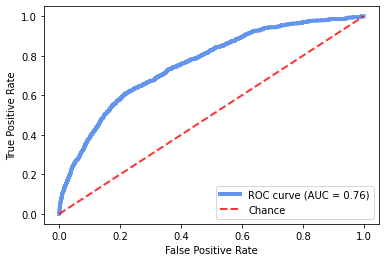

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


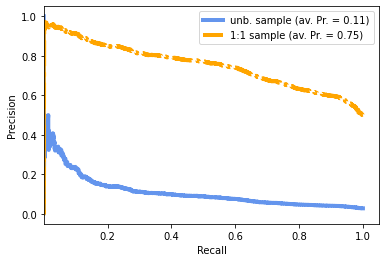

In [96]:
#make statistics for train/testing split from first stage
#the figures generated here are used in the paper

#the test below is the experiment test sample for all cities
#this file is important because it contains the 70/30 split which is important for the training and testing
filename ="test_set_1594832153.p"
# loading the data
testset = pd.read_pickle(os.path.join(path, filename))
testset.info()

# only set corpus_data to be the testset for specific cities
# https://stackoverflow.com/questions/25224545/filtering-multiple-items-in-a-multi-index-python-panda-dataframe

testset_filt = testset[testset.index.get_level_values(0).isin(['deir-ez-zor'])]
corpus_data=testset_filt


#call within first stage


corpus_data.destroyed=corpus_data.destroyed.astype(int)


y_train=corpus_data.destroyed
preds=corpus_data.prediction
weight = y_train.shape[0]/(2*np.bincount(y_train))
weightloss=weight[1]/weight[0]
print("this means the zeros have a weight that is", weightloss, "times higher")

unb_weights=class_weight.compute_sample_weight({0:1,1:1}, y_train)

b_weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y_train)



print("the AUC is", roc_auc_score(y_train, preds, sample_weight=b_weights))
print("precision (scan sample)", precision_score(y_train, corpus_data.prediction.round()==1, sample_weight=unb_weights))
print("precision (1:1 sample)", precision_score(y_train, corpus_data.prediction.round()==1, sample_weight=b_weights))


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precs = []

avprecs=[]

i=1

fpr, tpr, thresholds = roc_curve(y_train, preds, sample_weight=b_weights)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
        
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

plt.plot(fpr, tpr, lw=4, color='cornflowerblue',
    label='ROC curve (AUC = %0.2f)' % (roc_auc))

    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig(spitout+'cv_roc.pdf')
plt.show()


precision, recall, thresholds = precision_recall_curve(y_train, preds, sample_weight=unb_weights)
avprec=average_precision_score(y_train, preds, sample_weight=unb_weights)

plt.plot(recall, precision, lw=4, color='cornflowerblue',
    label='unb. sample (av. Pr. = %0.2f)' % (avprec))

precision, recall, thresholds = precision_recall_curve(y_train, preds, sample_weight=b_weights)
avprec=average_precision_score(y_train, preds, sample_weight=b_weights)
        
plt.plot(recall, precision, lw=4, linestyle='-.', color='orange',
    label='1:1 sample (av. Pr. = %0.2f)' % (avprec))

        
plt.xlim([0.001, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision Recall Curves')
plt.legend(loc="upper right")
plt.savefig(spitout+'precision_recall_first_stage_all.pdf')
plt.savefig(spitout+'precision_recall_first_stage_all.eps')
plt.show()

In [97]:
#check by hand for threshold that gets to TPR=0.5
threshold=0.8515
print("")
print("high threshold to get to tpr of 0.5")
print("recall on the positives is ", recall_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=b_weights))
print("precision on the positives at this threshold is (scan sample) ", precision_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=unb_weights))
print("precision on the positives at this threshold is (1:1 sample) ", precision_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=b_weights))


high threshold to get to tpr of 0.5
recall on the positives is  0.37818696883852304
precision on the positives at this threshold is (scan sample)  0.10308880308880308
precision on the positives at this threshold is (1:1 sample)  0.7993410463705859


In [98]:
#second threshold for text
threshold=0.5953
print("")
print("threshold to get to tpr of 0.9")
print("recall on the positives is ", recall_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=b_weights))
print("precision on the positives at this threshold is (scan sample) ", precision_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=unb_weights))
print("precision on the positives at this threshold is (1:1 sample) ", precision_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=b_weights))

tn, fp, fn, tp = confusion_matrix(y_train, (corpus_data.prediction>threshold)==1).ravel()

print(tn, fp, fn, tp )
print("fpr", fp/(tn+fp))


threshold to get to tpr of 0.9
recall on the positives is  0.8668555240793193
precision on the positives at this threshold is (scan sample)  0.042782243970639636
precision on the positives at this threshold is (1:1 sample)  0.6076963801165897
10776 13693 94 612
fpr 0.5596060321222772


In [99]:
#reading in all cities for later application
#citylist=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]
citylist=["deir-ez-zor"]


citydata = {}
target="all"
#target="deir-ez-zor"
for cityname in citylist:
    print("reading " + cityname)
    citydata[cityname]=readcity(target, cityname)

    
#prepare training and test data by reading in all data
#alldata is a dataset containing labels and predicted values from the CNN for all observations
#this will be split into trainset and testset below using the indicators from the STATA merge command
#we do this by fist merging the entire with the test set of the CNN
#those observations that match (mached (3)) are then attributed to the test set in the second stage as well
#those observations that are only in the traindata (master only (1)) must therefore be training data

print("composing corpus data going through all cities")
print("**********************************************")

alldata=composetraining(target)
alldata.to_csv(spitout + target + "_noimages.csv", sep='\t', encoding='utf-8')
print('testset head',testset.head())
testset=testset.reset_index(level=['date'])
testset=testset.drop(['destroyed', 'no_analysis', 'prediction', 'annotation_date'], axis=1)
testset.info()
testset.to_csv(spitout + "testset.csv", sep='\t', encoding='utf-8')

#call stata to merge
dofile = path_for_stata+"merge-test-set-allcities.do"
cmd = [statapath, "-e", "do", dofile, target, path_for_stata, spitout_for_stata]
subprocess.call(cmd)

#this file is made in the stata do file
filename_city ="prediction_"+target+".csv"
#filename_city ="prediction_"+"deir-ez-zor"+".csv"


# loading the merged alldata as the corpus (this contains all data)
corpus = pd.read_csv(os.path.join(path, filename_city))
corpus.info()

#make summary statistics

df_by_city = corpus.groupby(['city'])
for date_loop, wave in df_by_city:
    print("observations for " + date_loop, wave.prediction.count())
    print("labels for " + date_loop, wave.destroyed.value_counts())

    
    
    
#take over train and test split from first stage
print('testset shape',testset.shape)
# change to capital letters to match format of table
testset = corpus['_merge'] == "Matched (3)"
corpus[testset].info()
# change to capital letters to match format of table
trainset = corpus['_merge'] == "Master only (1)"
corpus[trainset].info()

reading deir-ez-zor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98602 entries, 0 to 98601
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         98602 non-null  object 
 1   patch_id     98602 non-null  object 
 2   date         98602 non-null  object 
 3   destroyed    84723 non-null  float64
 4   latitude     98602 non-null  float64
 5   longitude    98602 non-null  float64
 6   no_analysis  98602 non-null  int64  
 7   prediction   98602 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.0+ MB
composing corpus data going through all cities
**********************************************
composing training data for all
appending deir-ez-zor
testset head                               annotation_date  destroyed   latitude  \
city   patch_id    date                                               
aleppo 10016-10336 2013-05-26             NaT        0.0  36.211793   
                

In [101]:
corpus[trainset].head()

,v1,city,patch_id,date,destroyed,latitude,longitude,no_analysis,prediction,pred_50recall,...,prediction_f2,sum2,count2,std2,sum,count,std,sum_bin,sum_bin2,_merge
0,0.0,deir-ez-zor,10016-1056,2013-10-24,0.0,35.355202,40.156578,0.0,0.430951,0.0,...,0.484712,9.183811,21.0,0.063675,4.073804,9.0,0.036751,0.0,0.0,Master only (1)
1,1.0,deir-ez-zor,10016-1056,2014-09-16,0.0,35.355202,40.156578,0.0,0.429875,0.0,...,0.480233,10.101437,21.0,0.132798,4.410462,9.0,0.108110,0.0,0.0,Master only (1)
2,2.0,deir-ez-zor,10016-1056,2014-10-15,0.0,35.355202,40.156578,0.0,0.484712,0.0,...,0.537410,10.258679,21.0,0.095030,4.367550,9.0,0.040268,0.0,0.0,Master only (1)
3,3.0,deir-ez-zor,10016-1056,2014-11-25,0.0,35.355202,40.156578,0.0,0.480233,0.0,...,0.476034,10.363358,21.0,0.082942,4.535769,9.0,0.033793,0.0,0.0,Master only (1)
4,4.0,deir-ez-zor,10016-1056,2016-04-17,0.0,35.355202,40.156578,0.0,0.537410,0.0,...,0.627708,9.693735,21.0,0.129478,4.100843,9.0,0.089523,0.0,1.0,Master only (1)


/tmp/ipykernel_18420/339993246.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_data2["count1"]=corpus_data2["count"]-1
/tmp/ipykernel_18420/339993246.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_data2["count2"]=corpus_data2["count2"]-1
/tmp/ipykernel_18420/339993246.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59548 entries, 0 to 59547
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          59548 non-null  int64  
 1   prediction     59548 non-null  float64
 2   destroyed      59548 non-null  float64
 3   prediction_l1  59548 non-null  float64
 4   prediction_l2  59548 non-null  float64
 5   prediction_f1  59548 non-null  float64
 6   prediction_f2  59548 non-null  float64
 7   std            59548 non-null  float64
 8   std2           59548 non-null  float64
 9   count          59548 non-null  float64
 10  count2         59548 non-null  float64
 11  sum_bin        59548 non-null  float64
 12  sum_bin2       59548 non-null  float64
 13  pred_c1        59548 non-null  float64
 14  pred_c2        59548 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 6.8 MB
data head    index  prediction  destroyed  prediction_l1  prediction_l2  prediction_f1  \
0 

/tmp/ipykernel_18420/339993246.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_data2["random_forest_pred"] = clf_RF.predict_proba(X_RF_dense)[:, 1]
/tmp/ipykernel_18420/339993246.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_data2["random_forest_pred_sp"] = clf_RF2.predict_proba(X_RF2_dense)[:, 1]
/tmp/ipykernel_18420/339993246.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Looking at  all
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25175 entries, 0 to 25174
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          25175 non-null  int64  
 1   prediction     25175 non-null  float64
 2   destroyed      25175 non-null  float64
 3   prediction_l1  25175 non-null  float64
 4   prediction_l2  25175 non-null  float64
 5   prediction_f1  25175 non-null  float64
 6   prediction_f2  25175 non-null  float64
 7   std            25175 non-null  float64
 8   std2           25175 non-null  float64
 9   count          25175 non-null  float64
 10  count2         25175 non-null  float64
 11  sum_bin        25175 non-null  float64
 12  sum_bin2       25175 non-null  float64
 13  pred_c1        25175 non-null  float64
 14  pred_c2        25175 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 2.9 MB
this means the zeros have a weight that is 34.6586402266289 times higher
app

/tmp/ipykernel_18420/3867983536.py:99: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_18420/3867983536.py:108: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


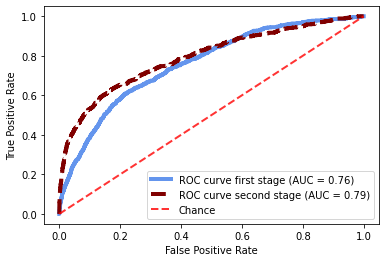

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


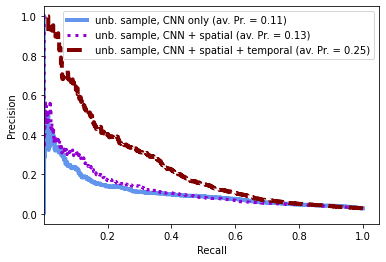

precision in the balanced sample with rf is 0.8176016501745308
precision in the unbalanced sample with rf is 0.2481451705504841
precision in the balanced sample with ens is 0.8036658629627622
precision in the unbalanced sample with ens is 0.23666941980432407
AUC with RF is 0.7916964252739518
AUC with ENS is 0.7783185685489543


In [102]:
#overall out of sample performance is calculated now

#collect training data (training set in corpus)
trainpartdata=corpus[trainset]

#save under functions the estimated model
functions=estimatemodel(trainpartdata, target)
#returns clf_RF, clf_RF2, clf_RF1, clf_RF3, y_within, preds_within, p_RF_within, p_RF2_within, p_RF1_within, p_RF3_within


#apply the model to all patches in the test sample
#save results in dataframe

#setting up dataframe for results stats
results = pd.DataFrame({"city": pd.Series([]), "date": pd.Series([]), "numberofdates": pd.Series([]),
                        "obs": pd.Series([]), "labels": pd.Series([]), "labels1": pd.Series([]), 
                        "AUC_1": pd.Series([]), "avprecision1to1_1": pd.Series([]), "avprecision_1": pd.Series([]),
                        "AUC_sp": pd.Series([]), "avprecision1to1_sp": pd.Series([]), "avprecision_sp": pd.Series([]),
                        "AUC_full": pd.Series([]), "avprecision1to1_full": pd.Series([]), "avprecision_full": pd.Series([]),
                        "AUC_temp": pd.Series([]), "avprecision1to1_temp": pd.Series([]), "avprecision_temp": pd.Series([]),
                        "AUC_full1l": pd.Series([]), "avprecision1to1_full1l": pd.Series([]), "avprecision_full1l": pd.Series([]),
                       })

#overall performance across all images is saved with target=all and date=alldates
performance=list(applymodel(functions[0], functions[1], functions[2], functions[3], target, corpus[testset],1))
#    returns (data_app['prediction'].count(),
#            data_app['destroyed'].count(),
#            data_app[data_app.destroyed == 1].shape[0],
#            roc_auc_score(y, preds), 
#            average_precision_score(y, preds, sample_weight=b_weights), 
#            average_precision_score(y, preds, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF2), 
#            average_precision_score(y, p_RF2, sample_weight=b_weights), 
#            average_precision_score(y, p_RF2, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF), 
#            average_precision_score(y, p_RF, sample_weight=b_weights), 
#            average_precision_score(y, p_RF, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF1), 
#            average_precision_score(y, p_RF1, sample_weight=b_weights), 
#            average_precision_score(y, p_RF1, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF3), 
#            average_precision_score(y, p_RF3, sample_weight=b_weights), 
#            average_precision_score(y, p_RF3, sample_weight=unb_weights))

date="alldates"
#replace test sample stats with overall stats for observations and labels
performance[0]=corpus.prediction.count()
performance[1]=corpus.destroyed.value_counts()[0]
performance[2]=corpus.destroyed.value_counts()[1]
resultswriter(target, date, len(corpus.date.value_counts()), performance)






In [103]:
pd.DataFrame(fpr).to_csv(path+"fprdata.csv")
pd.DataFrame(tpr).to_csv(path+"tprdata.csv")


In [106]:
corpus[corpus['city'] =='deir-ez-zor']

0         deir-ez-zor
1         deir-ez-zor
2         deir-ez-zor
3         deir-ez-zor
4         deir-ez-zor
             ...     
700202           hama
700203           hama
700204           hama
700205           hama
700206           hama
Name: city, Length: 700207, dtype: object

diplaying data for city: deir-ez-zor
****************************************************
available image dates
2013-10-24    14086
2014-09-16    14086
2014-10-15    14086
2014-11-25    14086
2016-04-17    14086
2016-05-25    14086
2016-07-06    14086
Name: date, dtype: int64
****************************************************
calculate performance in test sample
Looking at  deir-ez-zor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25175 entries, 0 to 25174
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          25175 non-null  int64  
 1   prediction     25175 non-null  float64
 2   destroyed      25175 non-null  float64
 3   prediction_l1  25175 non-null  float64
 4   prediction_l2  25175 non-null  float64
 5   prediction_f1  25175 non-null  float64
 6   prediction_f2  25175 non-null  float64
 7   std            25175 non-null  float64
 8   std2           25175 non-null  float64
 9   count      

/tmp/ipykernel_18420/1652198177.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  performance=list(applymodel(functions[0], functions[1], functions[2], functions[3], date_loop, wave[testset], 1))
/tmp/ipykernel_18420/3867983536.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_data2["count1"]=corpus_data2["count"]-1
/tmp/ipykernel_18420/3867983536.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_data2["count2"]=corpus_data2["count2"]-1
/tmp/ipykernel_184

apply temporal
apply spatial
apply one lag model


/tmp/ipykernel_18420/3867983536.py:99: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_18420/3867983536.py:108: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Producing graphs for deir-ez-zor


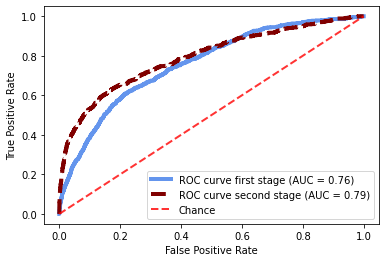

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


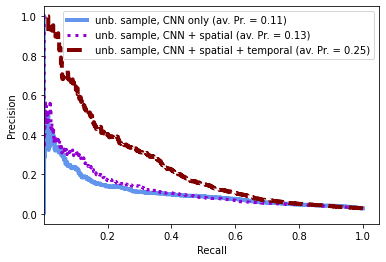

precision in the balanced sample with rf is 0.8176016501745308
precision in the unbalanced sample with rf is 0.2481451705504841
precision in the balanced sample with ens is 0.8036658629627622
precision in the unbalanced sample with ens is 0.23666941980432407
AUC with RF is 0.7916964252739518
AUC with ENS is 0.7783185685489543
          city      date  numberofdates      obs   labels  labels1     AUC_1  \
0          all  alldates           61.0  98602.0  82299.0   2424.0  0.758851   
0  deir-ez-zor  alldates            7.0  98602.0  82299.0   2424.0  0.758851   

   avprecision1to1_1  avprecision_1    AUC_sp  ...  avprecision_sp  AUC_full  \
0            0.75335       0.110297  0.749268  ...        0.125606  0.791696   
0            0.75335       0.110297  0.749268  ...        0.125606  0.791696   

   avprecision1to1_full  avprecision_full  AUC_temp  avprecision1to1_temp  \
0              0.817602          0.248145  0.771089              0.798181   
0              0.817602          0.2

0

In [107]:
#apply the model to all patches in the test sample by city waves and calculate performance
df_by_date = corpus[corpus['city'] =='deir-ez-zor'].groupby(['city'])
date="alldates"
df_by_date.describe()
for date_loop, wave in df_by_date:
    print("diplaying data for city:", date_loop)
    print("****************************************************")
    print("available image dates")
    print(wave.date.value_counts())
    print("****************************************************")
    print("calculate performance in test sample")
    performance=list(applymodel(functions[0], functions[1], functions[2], functions[3], date_loop, wave[testset], 1))
    #replace test sample stats with overall stats for observations and labels
    performance[0]=wave.prediction.count()
    performance[1]=wave.destroyed.value_counts()[0]
    performance[2]=wave.destroyed.value_counts()[1]
    #write results in separate df
    resultswriter(date_loop, date, len(wave.date.value_counts()), performance)

print(results)     
results.to_csv(spitout + "performance_stats.csv", sep='\t', encoding='utf-8')

#output tables with STATA
#this makes summary stats table and table 1
dofile = path_for_stata+"make_tables.do"
cmd = [statapath, "-e", "do", dofile, path_for_stata, spitout_for_stata]
subprocess.call(cmd)


In [130]:
#3) as a final step train second stage on entire labelled dataset
#functions=estimatemodel(corpus, target)
functions=estimatemodel(corpus, 'deir-ez-zor')
"""
#citylist=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]
citylist=["deir-ez-zor"]
for cityname in citylist:
    print("applying to " + cityname)
    date="alldates"
    applymodelsaveout(functions[0], functions[1], functions[2], functions[3], cityname, citydata[cityname])
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84723 entries, 0 to 84722
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          84723 non-null  int64  
 1   prediction     84723 non-null  float64
 2   destroyed      84723 non-null  float64
 3   prediction_l1  84723 non-null  float64
 4   prediction_l2  84723 non-null  float64
 5   prediction_f1  84723 non-null  float64
 6   prediction_f2  84723 non-null  float64
 7   std            84723 non-null  float64
 8   std2           84723 non-null  float64
 9   count          84723 non-null  float64
 10  count2         84723 non-null  float64
 11  sum_bin        84723 non-null  float64
 12  sum_bin2       84723 non-null  float64
 13  pred_c1        84723 non-null  float64
 14  pred_c2        84723 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 9.7 MB
data head    index  prediction  destroyed  prediction_l1  prediction_l2  prediction_f1  \
0 

'\n#citylist=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]\ncitylist=["deir-ez-zor"]\nfor cityname in citylist:\n    print("applying to " + cityname)\n    date="alldates"\n    applymodelsaveout(functions[0], functions[1], functions[2], functions[3], cityname, citydata[cityname])\n'

In [131]:
X_RF, y_within, X_RF_dense = functions

In [137]:
X_RF.iloc[1429:1434,6]

1429    inf
1430    inf
1431    inf
1432    inf
1433    inf
Name: pred_c2, dtype: float64

In [141]:
np.where(X_RF.values >= np.finfo(np.float32).max)

array([], dtype=int64)

In [138]:
X_RF.columns

Index(['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1',
       'prediction_f2', 'pred_c1', 'pred_c2', 'sum_bin', 'sum_bin2', 'std',
       'std2', 'count', 'count2'],
      dtype='object')

In [ ]:
clf_RF = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1)
X_RF.replace([np.inf, -np.inf], np.nan, inplace=True)
X_RF.dropna(subset=['pred_c2'], how="all", inplace=True)

clf_RF.fit(X_RF, y_within)
#p_RF_within = clf_RF.predict_proba(X_RF)[:, 1]